# Probando Series Temporales

In [2]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
import tensorflow as tf
import random
import yfinance as yf
from dotenv import load_dotenv
import os
from data_apis.enums import *
from data_apis.binance_api import *
from tqdm import tqdm

In [3]:
# Max Loss Function

def l_infinity_loss(y_true, y_pred):
    return tf.reduce_max(tf.abs(y_true - y_pred), axis=-1)

### Apple Series (Regimen Alcista)

[*********************100%***********************]  1 of 1 completed


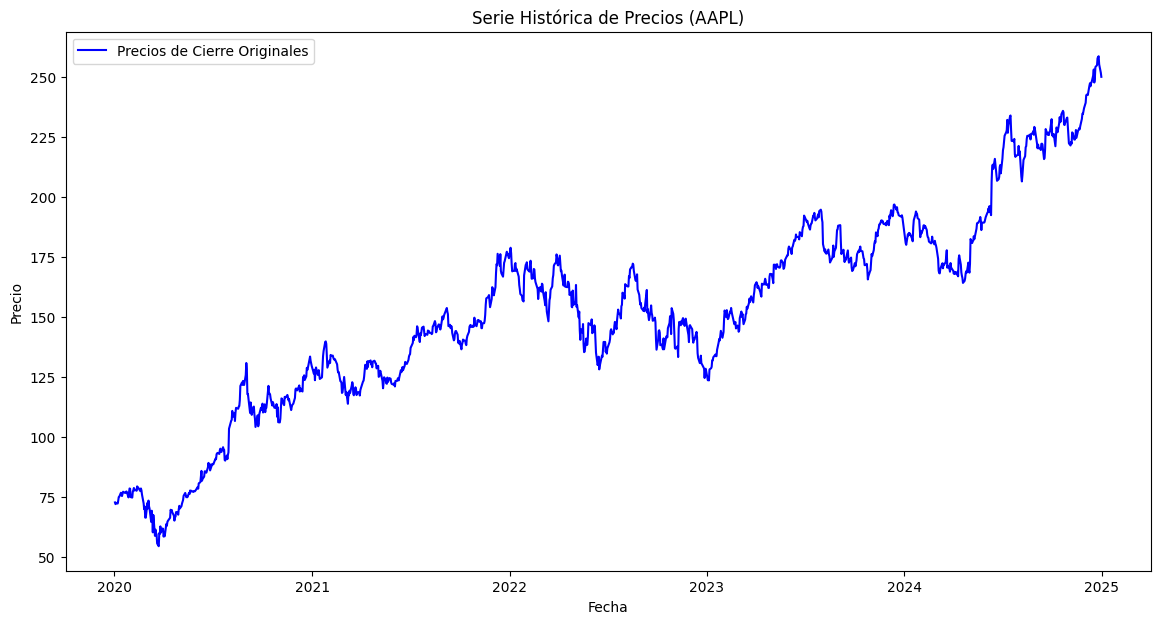

Training model with L1 loss function.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
Training model with L2 loss function.
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


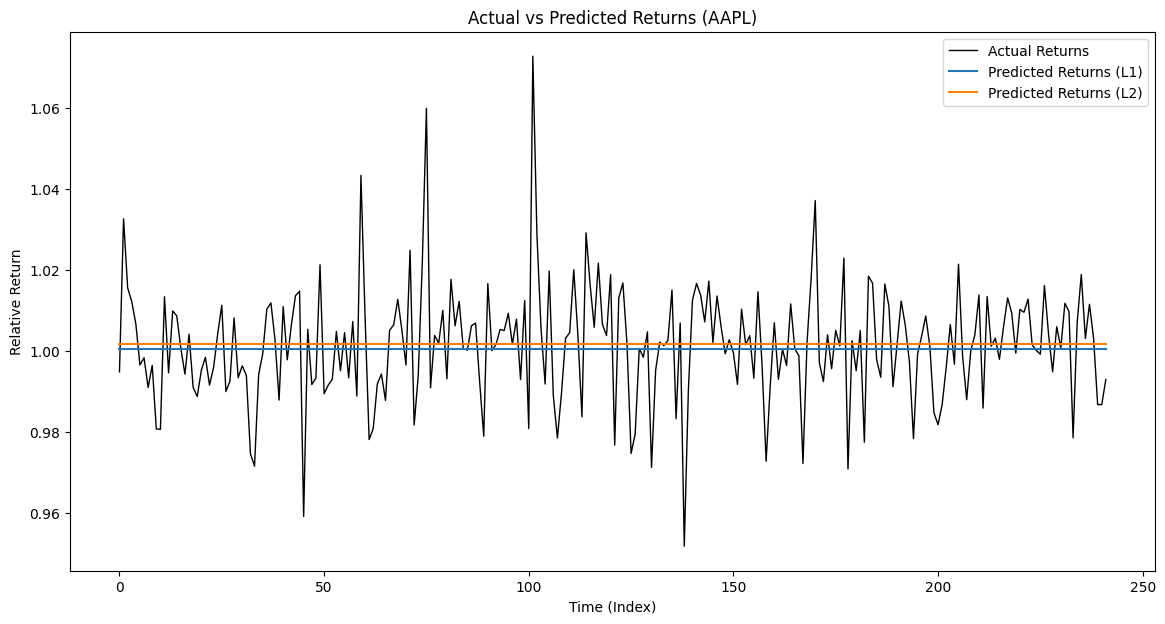

Mean-Mean/Median actual return: -0.000317
Mean Difference (L2 - L1): 0.001264


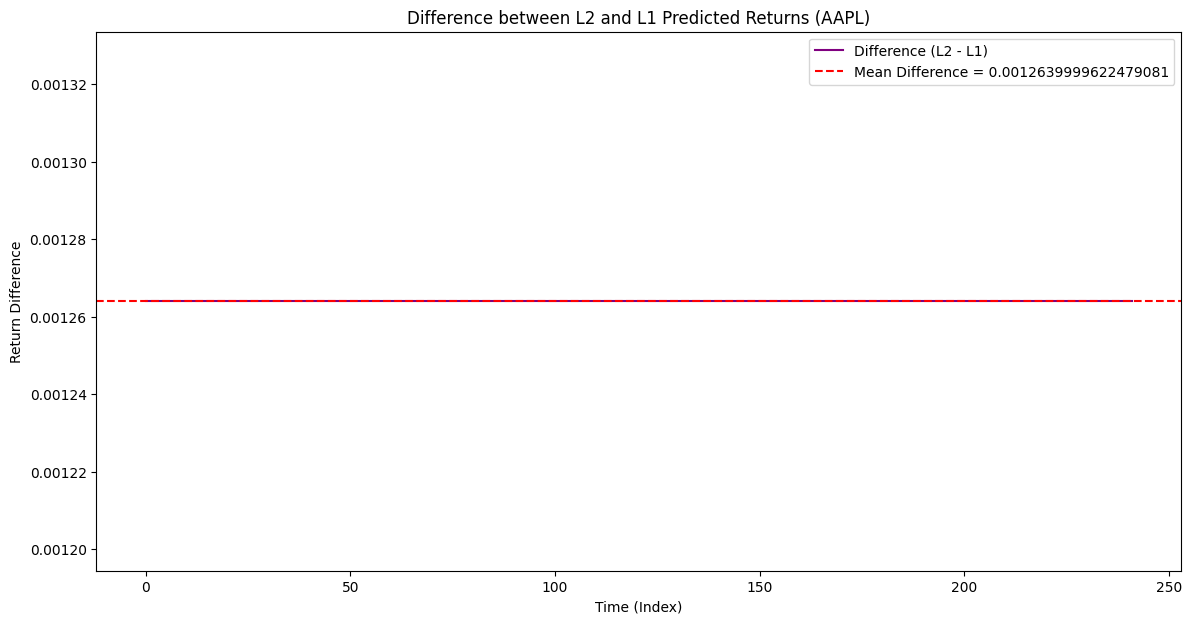

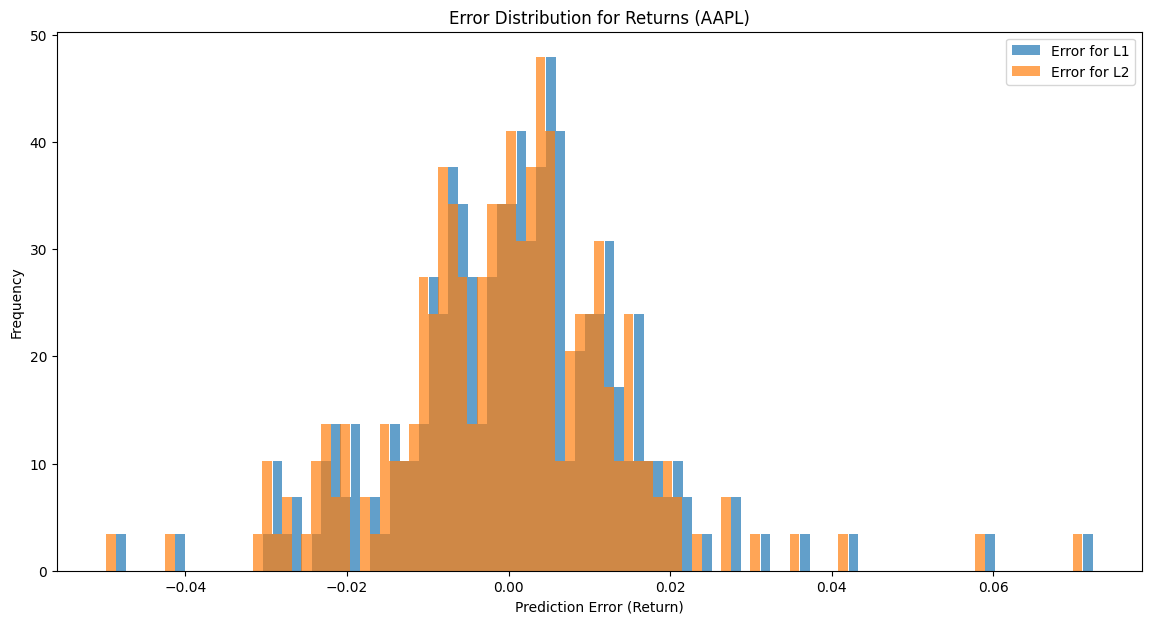

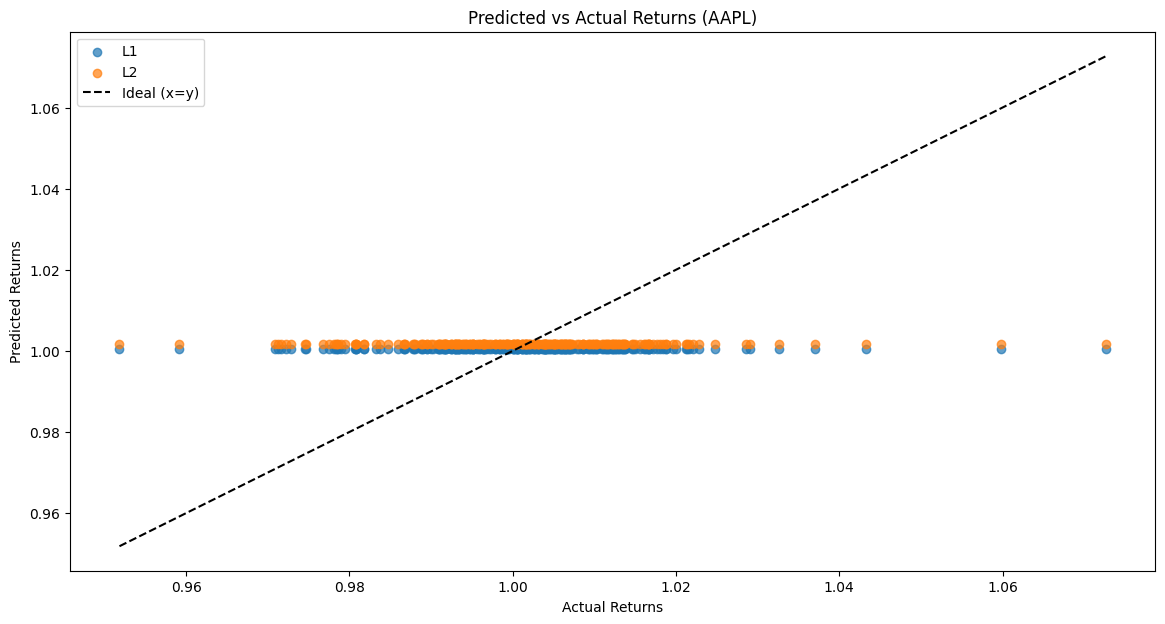

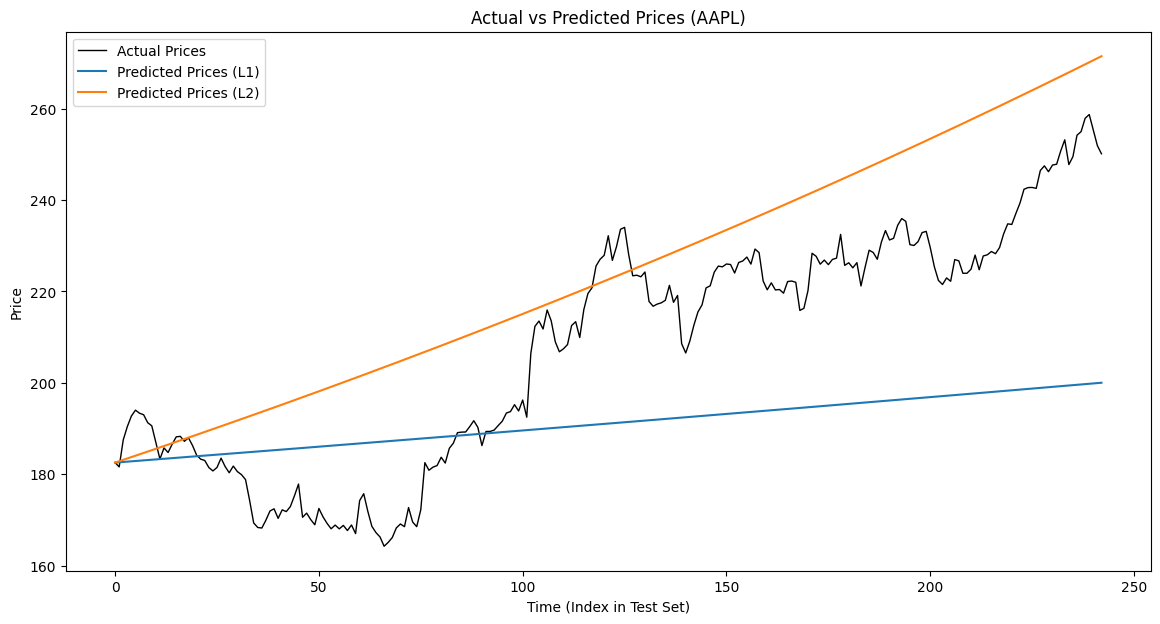

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

# Reproducibilidad
seed = 3254
np.random.seed(seed)
tf.random.set_seed(seed)
tf.data.experimental.enable_debug_mode()

# Funciones de pérdida
loss_functions = {
    "L1": "mae",
    "L2": "mse",
}

# Descargar datos
ticker = 'AAPL'
data = yf.download(ticker, start='2020-01-01', end='2025-01-01')
if data.empty:
    raise ValueError("No data downloaded.")

stock_prices = data['Close'].values.reshape(-1)

# Graficar precios
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['Close'], label='Precios de Cierre Originales', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title(f'Serie Histórica de Precios ({ticker})')
plt.legend()
plt.show()

# === INPUT: secuencia de precios hasta t ===
# === TARGET: retorno relativo entre t y t+1 = P_{t+1} / P_t

seq_length = 50
X = []
y = []

for i in range(len(stock_prices) - seq_length - 1):
    window = stock_prices[i:i + seq_length]
    ret_next = stock_prices[i + seq_length + 1] / stock_prices[i + seq_length]  # rendimiento relativo
    X.append(window)
    y.append(ret_next)

X = np.array(X)
y = np.array(y).reshape(-1, 1)

# Escalado con StandardScaler
price_scaler = StandardScaler()
return_scaler = StandardScaler()

X_scaled = price_scaler.fit_transform(X)
y_scaled = return_scaler.fit_transform(y)

# Train-test split
split = int(0.8 * len(X_scaled))
X_train, X_test = X_scaled[:split], X_scaled[split:]
y_train, y_test = y_scaled[:split], y_scaled[split:]

# Modelo
def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(64, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

# Entrenamiento
predict_returns = {}
for title, selected_loss in loss_functions.items():
    print(f"Training model with {title} loss function.")
    model = build_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)

    predictions_scaled = model.predict(X_test)
    predictions_ret = return_scaler.inverse_transform(predictions_scaled).flatten()
    predict_returns[title] = predictions_ret

# Retornos reales
actual_test_returns = return_scaler.inverse_transform(y_test).flatten()

# Reconstrucción de precios (uso de retornos relativos)
initial_test_price = stock_prices[split + seq_length]
actual_prices = [initial_test_price]
for r in actual_test_returns:
    next_price = actual_prices[-1] * r
    actual_prices.append(next_price)
actual_prices = np.array(actual_prices)

predicted_prices = {}
for title, predicted_ret in predict_returns.items():
    prices_list = [initial_test_price]
    for r in predicted_ret:
        next_price = prices_list[-1] * r
        prices_list.append(next_price)
    predicted_prices[title] = np.array(prices_list)

# === GRÁFICOS ===

# 1. Retornos: reales vs predichos
plt.figure(figsize=(14, 7))
plt.plot(actual_test_returns, label='Actual Returns', color='black', linewidth=1)
plt.plot(predict_returns["L1"], label='Predicted Returns (L1)')
plt.plot(predict_returns["L2"], label='Predicted Returns (L2)')
plt.xlabel('Time (Index)')
plt.ylabel('Relative Return')
plt.title(f'Actual vs Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 2. Diferencia entre L2 y L1
diff_series = predict_returns["L2"] - predict_returns["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 6)
diff_dist = np.mean(actual_test_returns) - np.median(actual_test_returns)
mean_rounded_dist = round(diff_dist, 6)

print("Mean-Mean/Median actual return:", mean_rounded_dist)
print("Mean Difference (L2 - L1):", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time (Index)')
plt.ylabel('Return Difference')
plt.title(f'Difference between L2 and L1 Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 3. Histograma de errores
errors_L1 = actual_test_returns - predict_returns["L1"]
errors_L2 = actual_test_returns - predict_returns["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Return)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Returns ({ticker})')
plt.legend()
plt.show()

# 4. Dispersión
plt.figure(figsize=(14, 7))
plt.scatter(actual_test_returns, predict_returns["L1"], alpha=0.7, label='L1')
plt.scatter(actual_test_returns, predict_returns["L2"], alpha=0.7, label='L2')
ideal_line = [min(actual_test_returns), max(actual_test_returns)]
plt.plot(ideal_line, ideal_line, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Predicted vs Actual Returns ({ticker})')
plt.legend()
plt.show()

# === GRÁFICOS DE PRECIOS ===

plt.figure(figsize=(14, 7))
plt.plot(actual_prices, label='Actual Prices', color='black', linewidth=1)
plt.plot(predicted_prices["L1"], label='Predicted Prices (L1)')
plt.plot(predicted_prices["L2"], label='Predicted Prices (L2)')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices ({ticker})')
plt.legend()
plt.show()


### Corn Futures Series (Serie Estable)

[*********************100%***********************]  1 of 1 completed


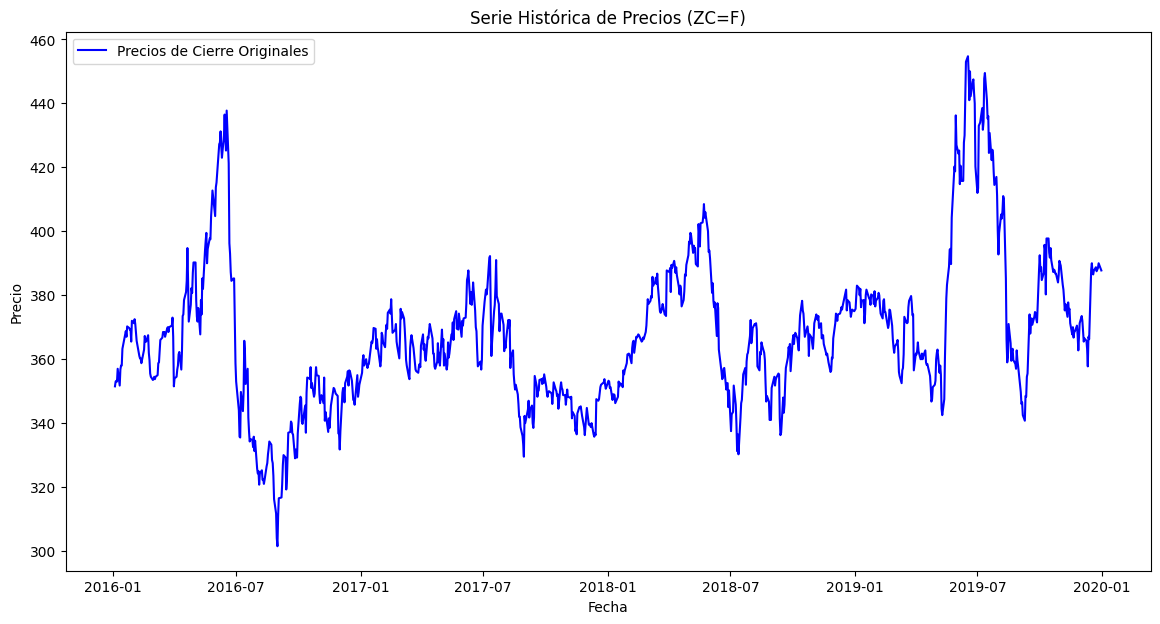

In [ ]:
# Seed for reproducibility
seed = 3254
np.random.seed(seed)
tf.random.set_seed(seed)
tf.data.experimental.enable_debug_mode()

# Loss functions dictionary
loss_functions = {
    "L1": "mae",
    "L2": "mse",
}

# Fetch historical data for Gold Futures using ticker "GC=F" from 2015 to 2020
ticker = 'ZC=F'
data = yf.download(ticker, start='2016-01-01', end='2020-01-01')
if data.empty:
    raise ValueError("No data downloaded. Please check the ticker, date range, or your internet connection.")

stock_prices = data['Close'].values
stock_prices = stock_prices.reshape(-1)  # Ensure it's 1D

# Plot de los precios originales (serie histórica)
plt.figure(figsize=(14,7))
plt.plot(data.index, data['Close'], label='Precios de Cierre Originales', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title(f'Serie Histórica de Precios ({ticker})')
plt.legend()
plt.show()

# Calculate log-returns from gold prices
prices_series = pd.Series(stock_prices)
pd_stock = prices_series.shift(1)
returns = np.log(prices_series) - np.log(pd_stock)
returns = returns.dropna()
returns = returns.values  # 1D array of log-returns

# Compute mean and standard deviation (to later invert the standardization)
returns_mean = returns.mean()
returns_std = returns.std()
standardized_returns = (returns - returns_mean) / returns_std  # minmax scaler

# Define sequence length (number of past standardized returns to use as input)
seq_length = 40

# Prepare input sequences and corresponding targets from standardized returns
X = []
y = []
for i in range(len(standardized_returns) - seq_length):
    X.append(standardized_returns[i:i + seq_length])
    y.append(standardized_returns[i + seq_length])
    
X = np.array(X)
y = np.array(y)

# Split into training and testing sets (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split].reshape(-1, 1), y[split:].reshape(-1, 1)

# Model building function
def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

# Dictionary to store predicted returns (after inverse transformation)
predict_returns = {}

In [166]:
for title, selected_loss in loss_functions.items():
    print(f"Training model with {title} loss function.")
    model = build_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
    
    # Predict on the test set (predictions are in standardized space)
    predictions_std = model.predict(X_test).flatten()
    
    # Inverse transform to obtain returns in original scale:
    predictions_ret = predictions_std * returns_std + returns_mean
    predict_returns[title] = predictions_ret

Training model with L1 loss function.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Training model with L2 loss function.
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [167]:
# Print a few predicted returns for each loss function
for loss_name, preds in predict_returns.items():
    print(f"{loss_name} predicted returns (first 10): {preds[:10]}")

# The first label in the test set corresponds to the stock price at index (split + seq_length) in stock_prices
initial_test_price = stock_prices[split + seq_length]

# Reconstruct the actual prices for the test period from the actual test returns
# First, un-standardize the actual test returns:

actual_test_returns = y_test.flatten() * returns_std + returns_mean
actual_prices = [initial_test_price]
for r in actual_test_returns:
    next_price = actual_prices[-1] * np.exp(r)
    actual_prices.append(next_price)
actual_prices = np.array(actual_prices)

# Reconstruct predicted prices for each loss function using:
# P_{t+1} = P_t * exp(r_{t+1})
predicted_prices = {}
for title, pred_ret in predict_returns.items():
    prices_list = [initial_test_price]
    for i, r in enumerate(pred_ret):
        next_price = actual_prices[i] * np.exp(r)
        prices_list.append(next_price)
    predicted_prices[title] = np.array(prices_list)

L1 predicted returns (first 10): [ 0.00272907 -0.00327572  0.00410119 -0.00725858  0.01226996 -0.00522523
  0.00357343  0.01581632 -0.00463695 -0.00164367]
L2 predicted returns (first 10): [ 0.00302023  0.00372374  0.00309551 -0.00920916 -0.00171901 -0.0038602
  0.00056651  0.02606431 -0.00337244 -0.02131464]


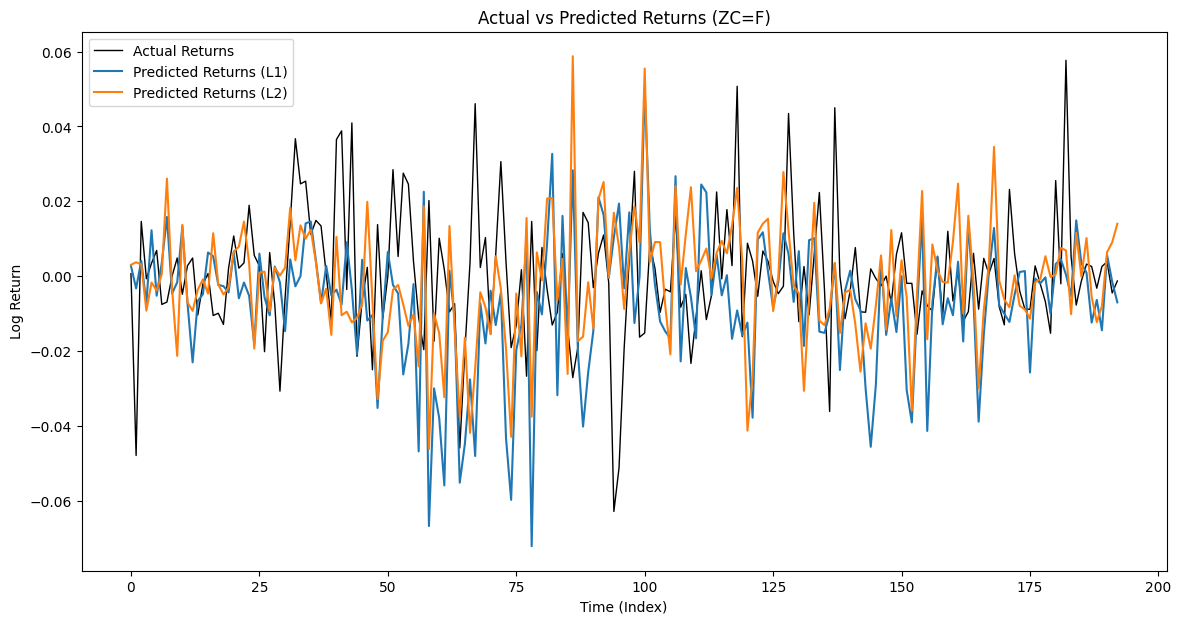

Observed Mean Difference between Mean and Median for prices: 0.000191
Observed Mean Difference between L2 and L1 predicted returns: 0.005199


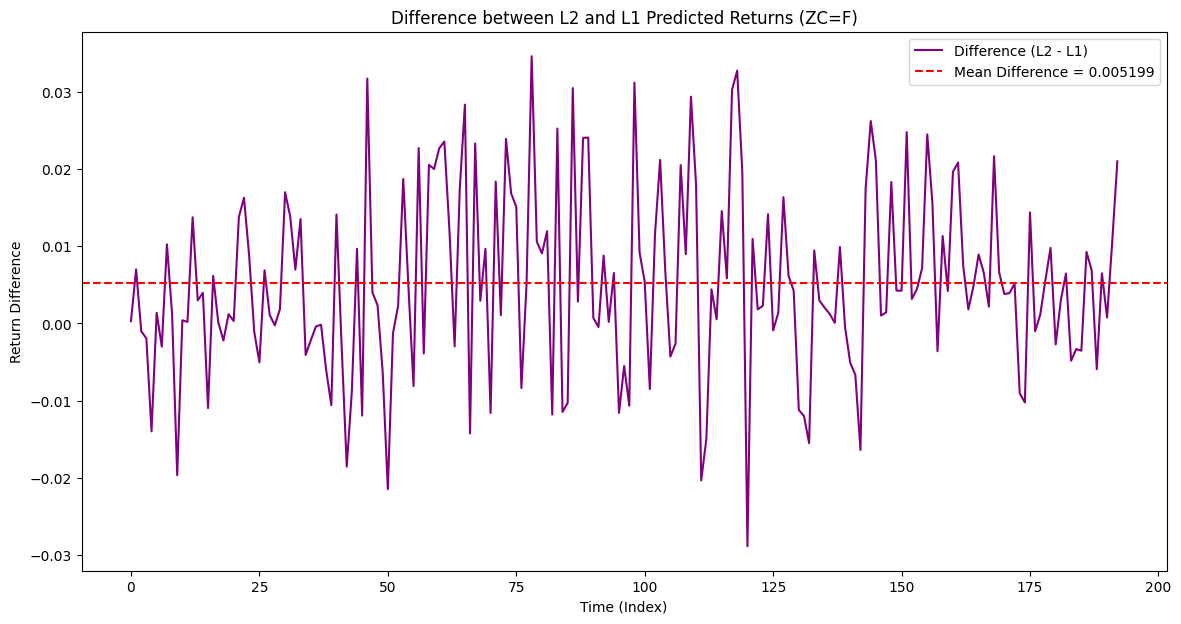

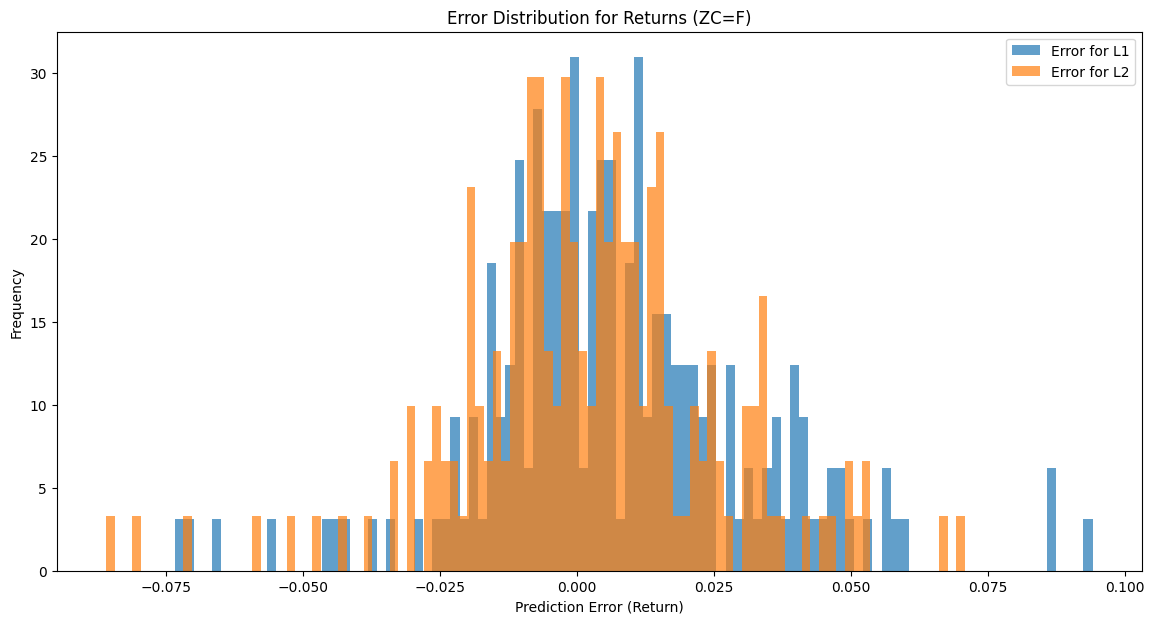

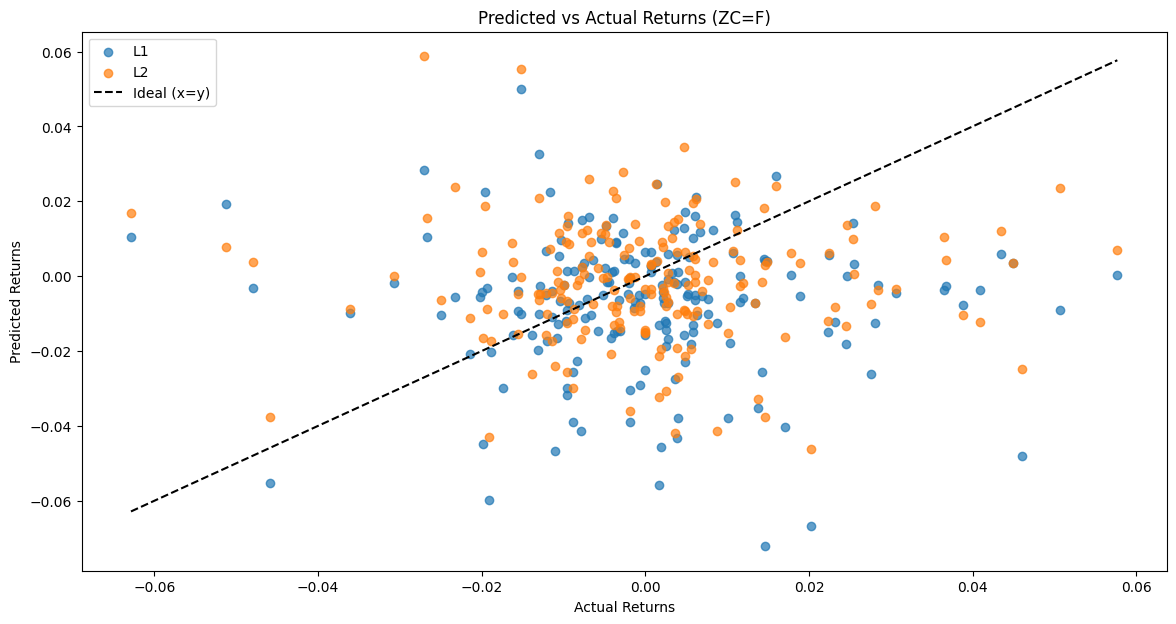

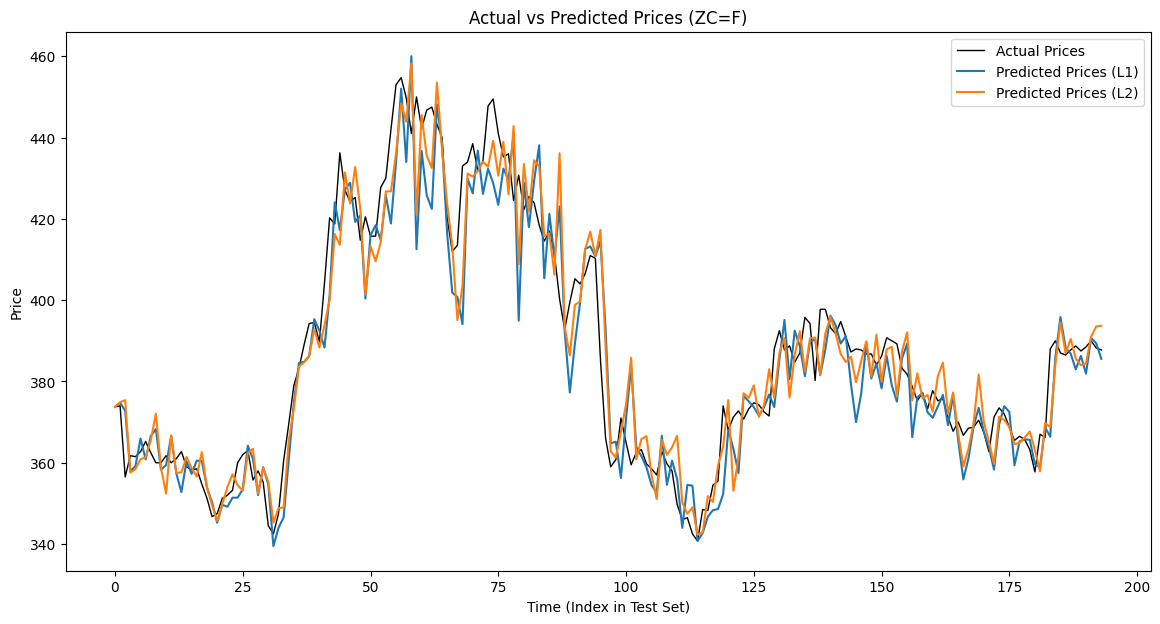

Observed Mean Difference between Mean and Median for prices: 5.41366
Observed Mean Difference between L2 and L1 predicted prices: 2.007571


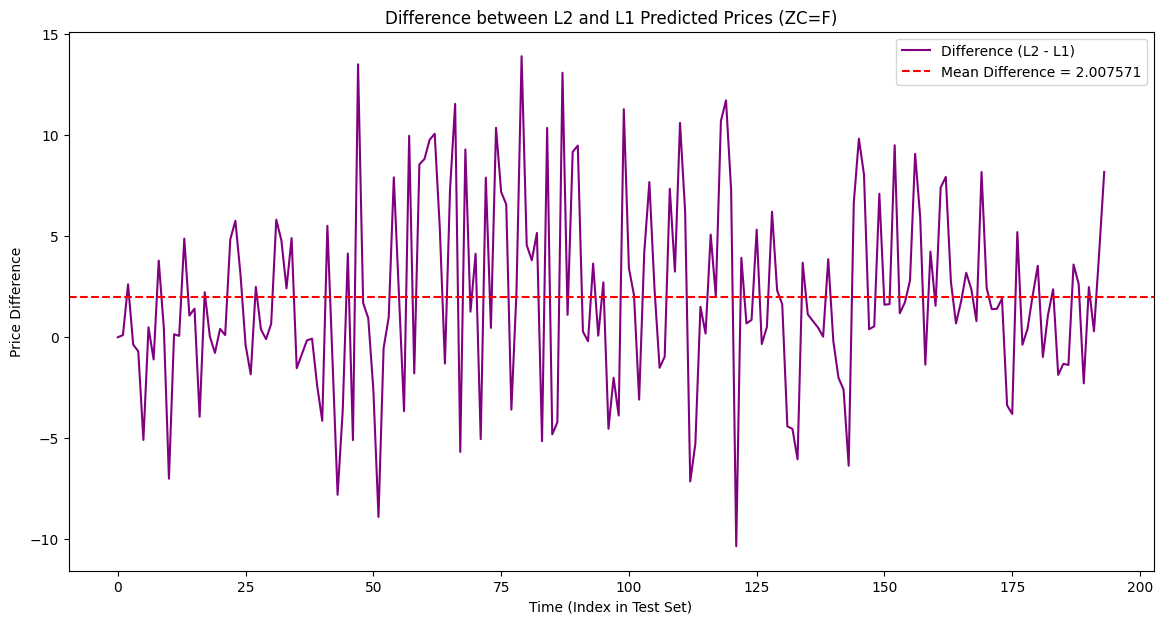

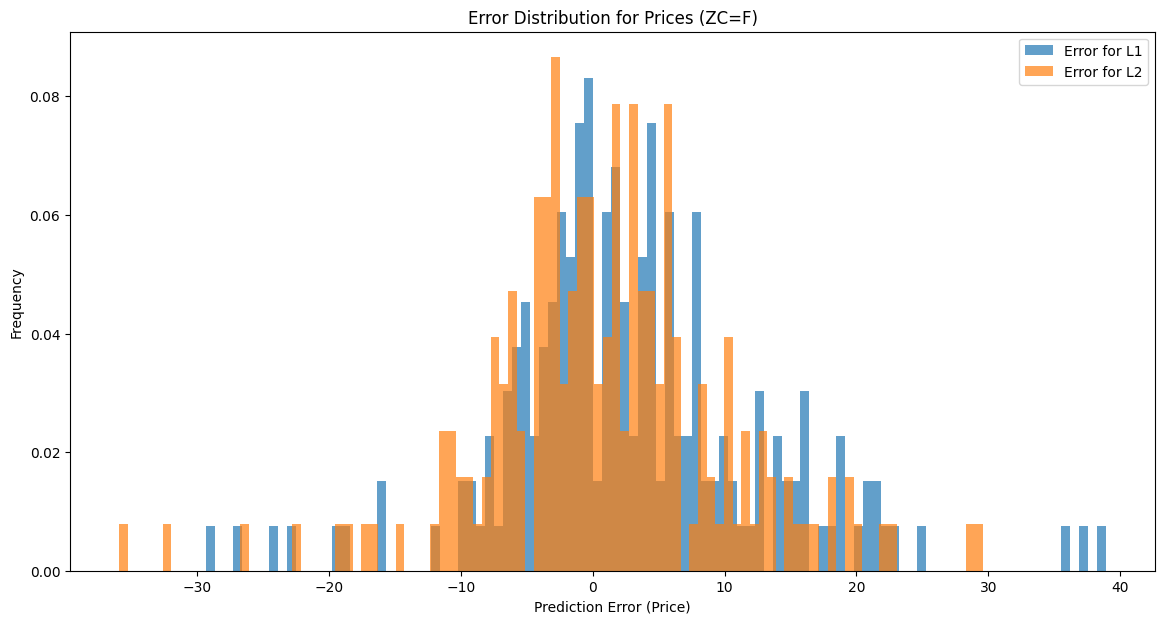

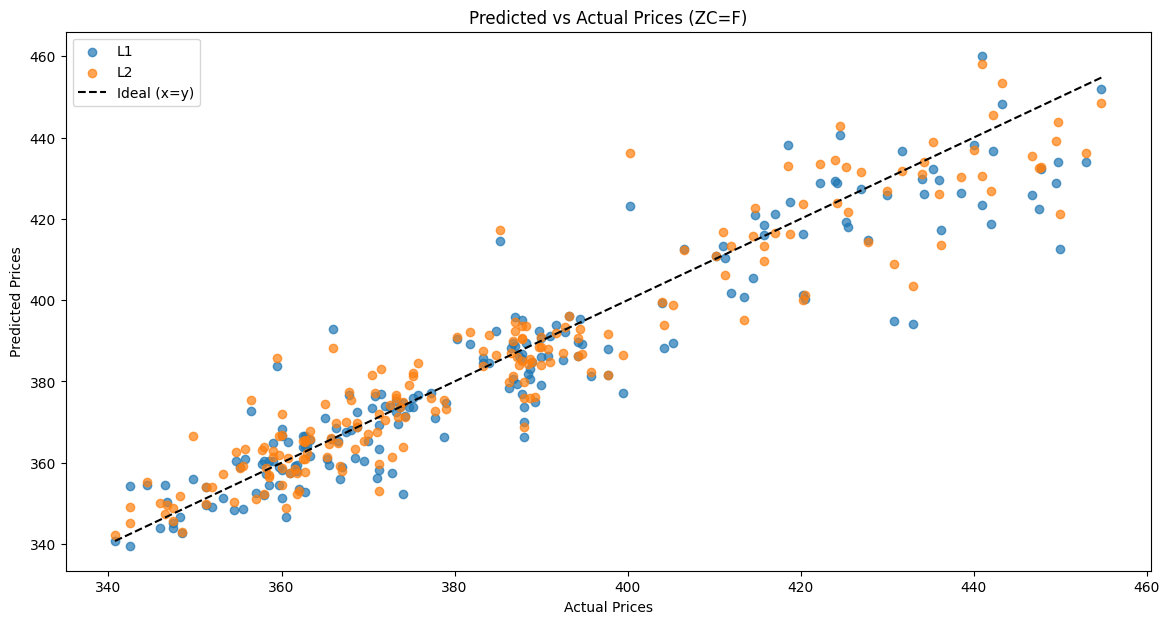

In [168]:
# Un-standardize the test returns
actual_returns = y_test.flatten() * returns_std + returns_mean
start_index = 0  # They are aligned with the test set

# 1. Line Plot: Actual vs Predicted Returns
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_returns)), actual_returns, 
         label='Actual Returns', color='black', linewidth=1)
plt.plot(range(len(predict_returns["L1"])), predict_returns["L1"], 
         label='Predicted Returns (L1)')
plt.plot(range(len(predict_returns["L2"])), predict_returns["L2"], 
         label='Predicted Returns (L2)')
plt.xlabel('Time (Index)')
plt.ylabel('Log Return')
plt.title(f'Actual vs Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 2. Difference between L2 and L1 Predicted Returns
diff_series = predict_returns["L2"] - predict_returns["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 6)
diff_dist = np.mean(actual_returns) - np.median(actual_returns)
diff_mean_dist = np.mean(diff_dist)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted returns:", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time (Index)')
plt.ylabel('Return Difference')
plt.title(f'Difference between L2 and L1 Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Returns (Error = Actual - Predicted)
errors_L1 = actual_returns - predict_returns["L1"]
errors_L2 = actual_returns - predict_returns["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Return)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Returns ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Returns
plt.figure(figsize=(14, 7))
plt.scatter(actual_returns, predict_returns["L1"], alpha=0.7, label='L1')
plt.scatter(actual_returns, predict_returns["L2"], alpha=0.7, label='L2')
ideal_line = [min(actual_returns), max(actual_returns)]
plt.plot(ideal_line, ideal_line, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Predicted vs Actual Returns ({ticker})')
plt.legend()
plt.show()

##########################################################

# Both actual_prices and predicted_prices are assumed to have been reconstructed (length = len(y_test)+1)

# 1. Line Plot: Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_prices)), actual_prices, 
         label='Actual Prices', color='black', linewidth=1)
plt.plot(range(len(predicted_prices["L1"])), predicted_prices["L1"], 
         label='Predicted Prices (L1)')
plt.plot(range(len(predicted_prices["L2"])), predicted_prices["L2"], 
         label='Predicted Prices (L2)')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Difference between L2 and L1 Predicted Prices
diff_series_prices = predicted_prices["L2"] - predicted_prices["L1"]
diff_mean_prices = np.mean(diff_series_prices)
mean_rounded_prices = round(diff_mean_prices, 6)
diff_dist_prices = np.mean(actual_prices) - np.median(actual_prices)
diff_mean_dist = np.mean(diff_dist_prices)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted prices:", mean_rounded_prices)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series_prices)), diff_series_prices, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean_prices, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded_prices}')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price Difference')
plt.title(f'Difference between L2 and L1 Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Prices (Error = Actual - Predicted)
errors_prices_L1 = actual_prices - predicted_prices["L1"]
errors_prices_L2 = actual_prices - predicted_prices["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_prices_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_prices_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Price)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Prices ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Prices
plt.figure(figsize=(14, 7))
plt.scatter(actual_prices, predicted_prices["L1"], alpha=0.7, label='L1')
plt.scatter(actual_prices, predicted_prices["L2"], alpha=0.7, label='L2')
ideal_line_prices = [min(actual_prices), max(actual_prices)]
plt.plot(ideal_line_prices, ideal_line_prices, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Predicted vs Actual Prices ({ticker})')
plt.legend()
plt.show()


### Bitcoin Series (Régimen Bajista)


Succesfully connected to the Binance Spot API at 2025-04-04 03:16:32.725165 

Succesfully connected to the Binance Futures API at 2025-04-04 03:16:33.038033 



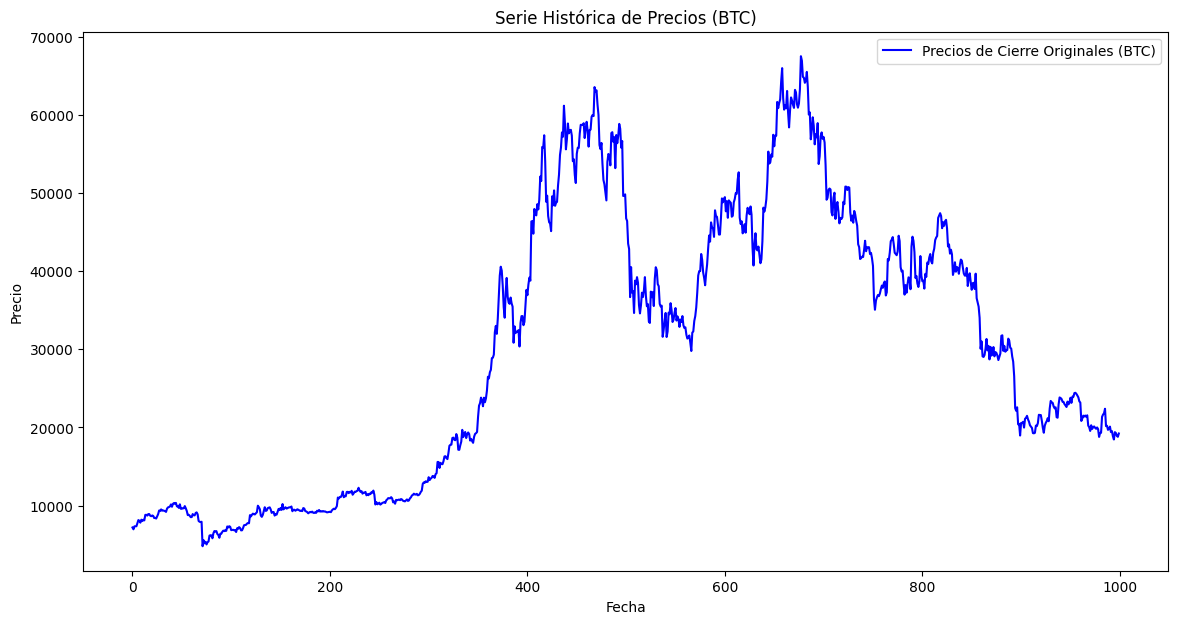

In [169]:
seed = 3254
np.random.seed(seed)
tf.random.set_seed(seed)
tf.data.experimental.enable_debug_mode()

loss_functions = {
    "L1": "mae",
    "L2": "mse",
}

load_dotenv(".env")
api_key = os.getenv("BINANCE_API_KEY")
secret_key = os.getenv("BINANCE_SECRET_KEY")
exchange_name = "binance"  # o el enum correspondiente

# Inicializar la API de Binance (asegúrate de que BinanceProvider esté implementado)
binance_api = BinanceProvider(api_key=api_key, api_secret=secret_key)
binance_api.connect()

# Definir rango de fechas: 2020-01-01 a 2025-01-01
start = datetime(2020, 1, 1)
end = datetime(2025, 1, 1)
ticker = "BTCUSDT"

# Obtener datos históricos de BTC (frecuencia diaria)
btc_klines = binance_api.get_market_data(symbol=TokenPairs.btc_usdt, freq="1d", start=start, end=end)
# Suponemos que btc_klines es un DataFrame con una columna 'close' y un índice con las fechas.
token_prices = np.array(btc_klines['close'])
token_prices = token_prices.reshape(-1)  # Asegurarse de que es 1D

plt.figure(figsize=(14,7))
plt.plot(range(0,len(btc_klines['close'])), btc_klines['close'], label='Precios de Cierre Originales (BTC)', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Serie Histórica de Precios (BTC)')
plt.legend()
plt.show()

prices_series = pd.Series(token_prices)
pd_stock = prices_series.shift(1)
returns = np.log(prices_series) - np.log(pd_stock)
returns = returns.dropna()
returns = returns.values  # Array 1D de log-retornos

# Calcular media y desviación estándar (para invertir la estandarización)
returns_mean = returns.mean()
returns_std = returns.std()
standardized_returns = (returns - returns_mean) / returns_std

# Definir la longitud de la secuencia (número de retornos pasados a usar como entrada)
seq_length = 50

X = []
y = []
for i in range(len(standardized_returns) - seq_length):
    X.append(standardized_returns[i:i + seq_length])
    y.append(standardized_returns[i + seq_length])
    
X = np.array(X)
y = np.array(y)

# Dividir en entrenamiento y test (80% entrenamiento, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split].reshape(-1, 1), y[split:].reshape(-1, 1)

def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

predict_returns = {} 

In [170]:
for title, selected_loss in loss_functions.items():
    print(f"Training model with {title} loss function.")
    model = build_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
    
    # Predict on the test set (predictions are in standardized space)
    predictions_std = model.predict(X_test).flatten()
    
    # Inverse transform to obtain returns in original scale:
    predictions_ret = predictions_std * returns_std + returns_mean
    predict_returns[title] = predictions_ret

Training model with L1 loss function.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
Training model with L2 loss function.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [171]:
# Print a few predicted returns for each loss function
for loss_name, preds in predict_returns.items():
    print(f"{loss_name} predicted returns (first 10): {preds[:10]}")

# The first label in the test set corresponds to the stock price at index (split + seq_length) in stock_prices
initial_test_price = stock_prices[split + seq_length]

# Reconstruct the actual prices for the test period from the actual test returns
# First, un-standardize the actual test returns:

actual_test_returns = y_test.flatten() * returns_std + returns_mean
actual_prices = [initial_test_price]
for r in actual_test_returns:
    next_price = actual_prices[-1] * np.exp(r)
    actual_prices.append(next_price)
actual_prices = np.array(actual_prices)

# Reconstruct predicted prices for each loss function using:
# P_{t+1} = P_t * exp(r_{t+1})
predicted_prices = {}
for title, pred_ret in predict_returns.items():
    prices_list = [initial_test_price]
    for i, r in enumerate(pred_ret):
        next_price = actual_prices[i] * np.exp(r)
        prices_list.append(next_price)
    predicted_prices[title] = np.array(prices_list)

L1 predicted returns (first 10): [ 0.02258158 -0.04400652 -0.03710507  0.0240225  -0.009618    0.00356703
  0.02166588 -0.03593287 -0.04225641 -0.01892892]
L2 predicted returns (first 10): [ 0.04998879  0.01630908 -0.08054467  0.03867091 -0.03933743  0.033556
 -0.00054419 -0.02750257 -0.00103321  0.00567559]


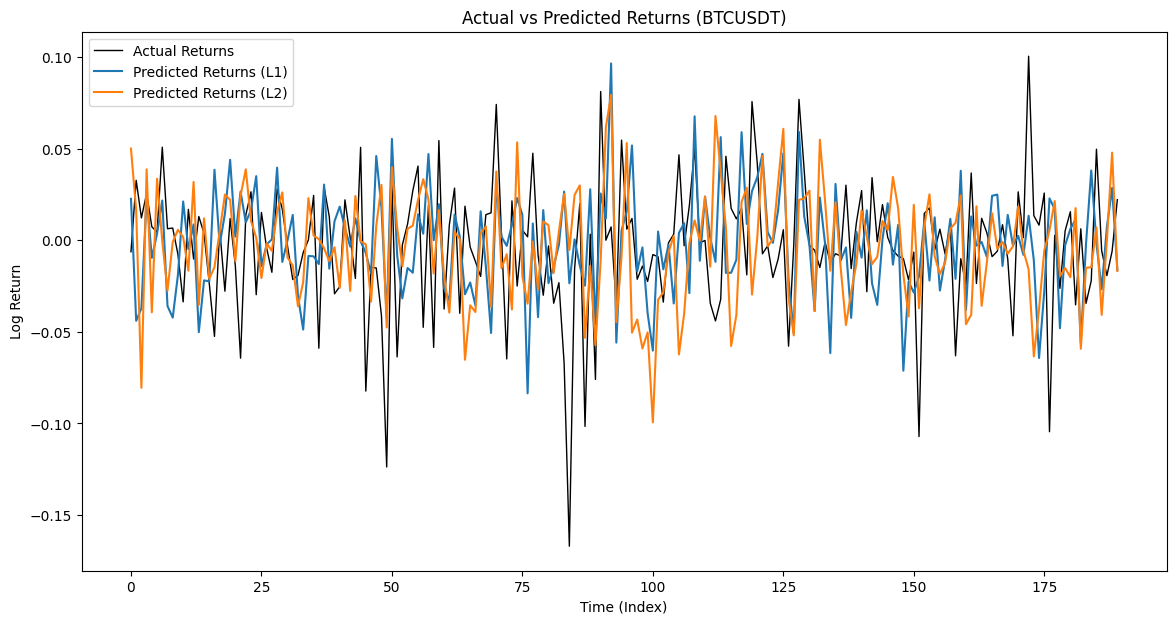

Observed Mean Difference between Mean and Median for prices: -0.001422
Observed Mean Difference between L2 and L1 predicted returns: -0.002162


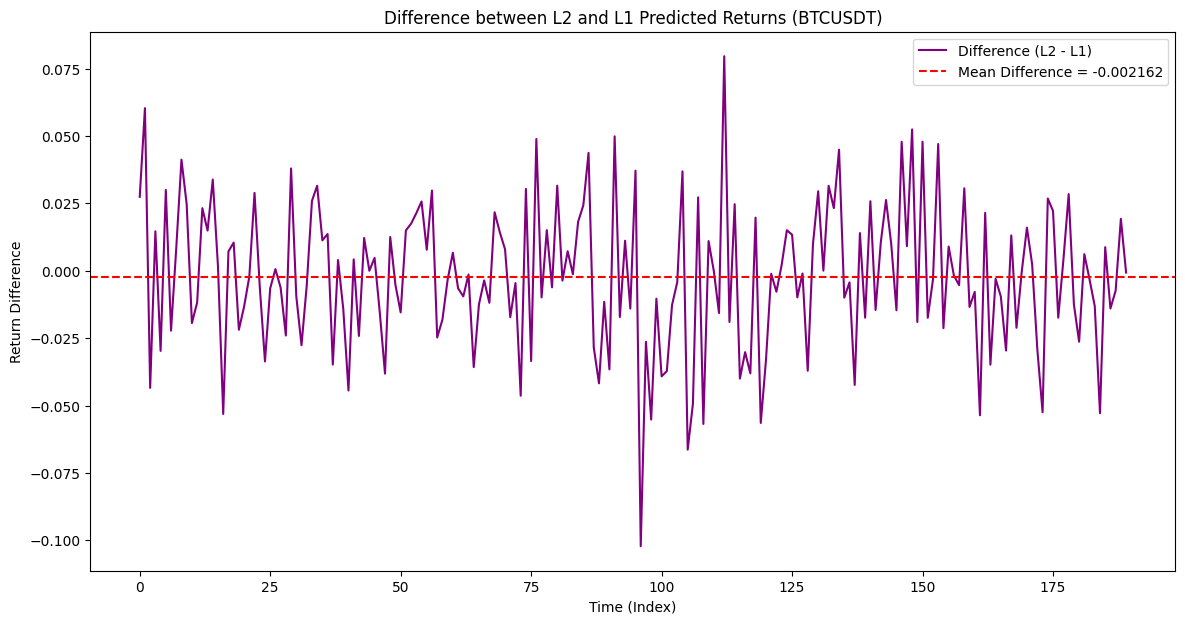

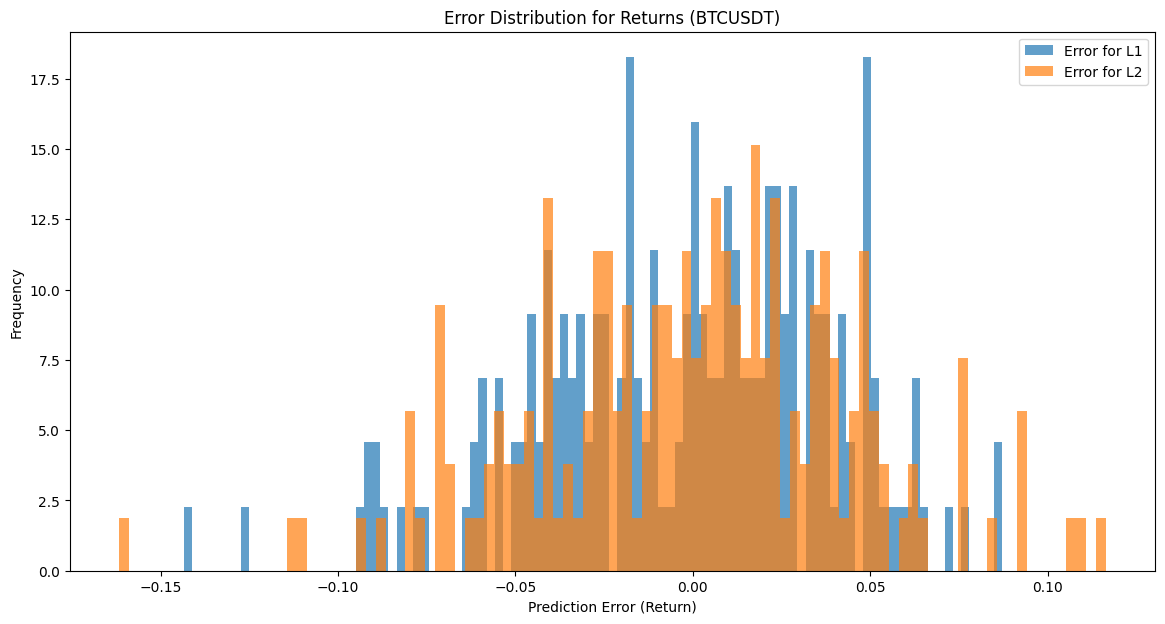

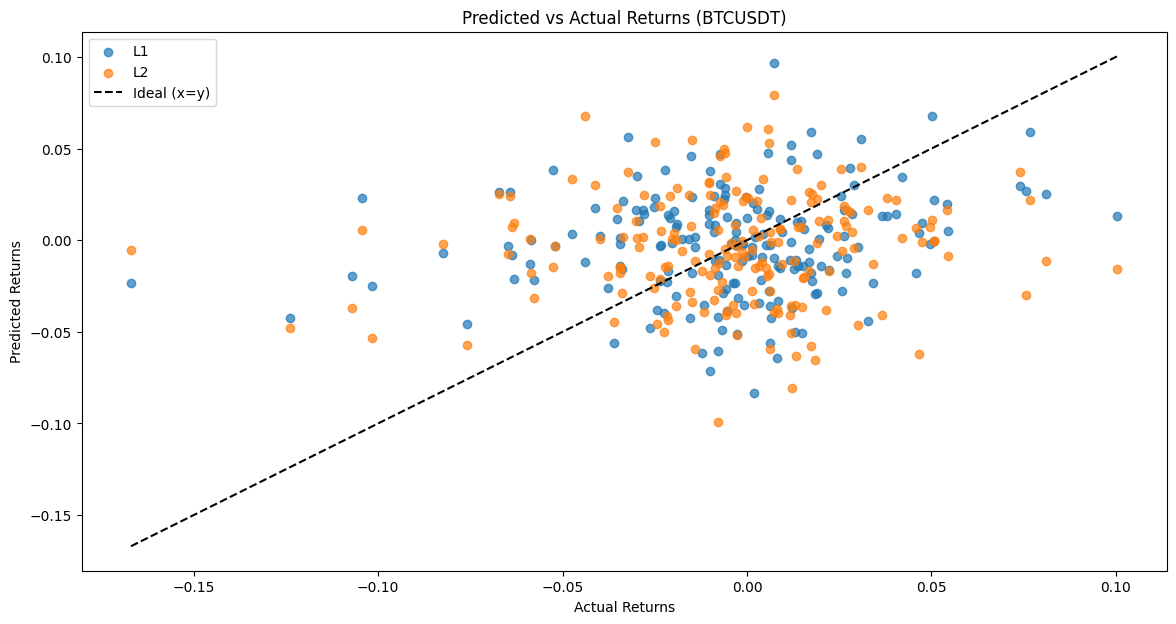

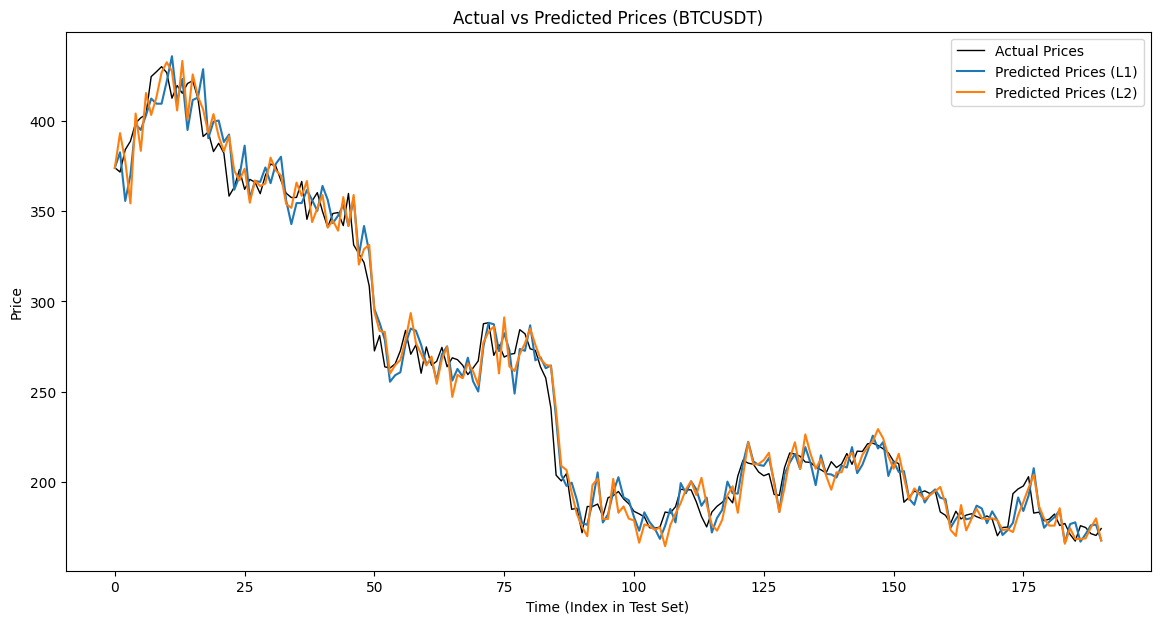

Observed Mean Difference between Mean and Median for prices: 40.413473
Observed Mean Difference between L2 and L1 predicted prices: -0.313029


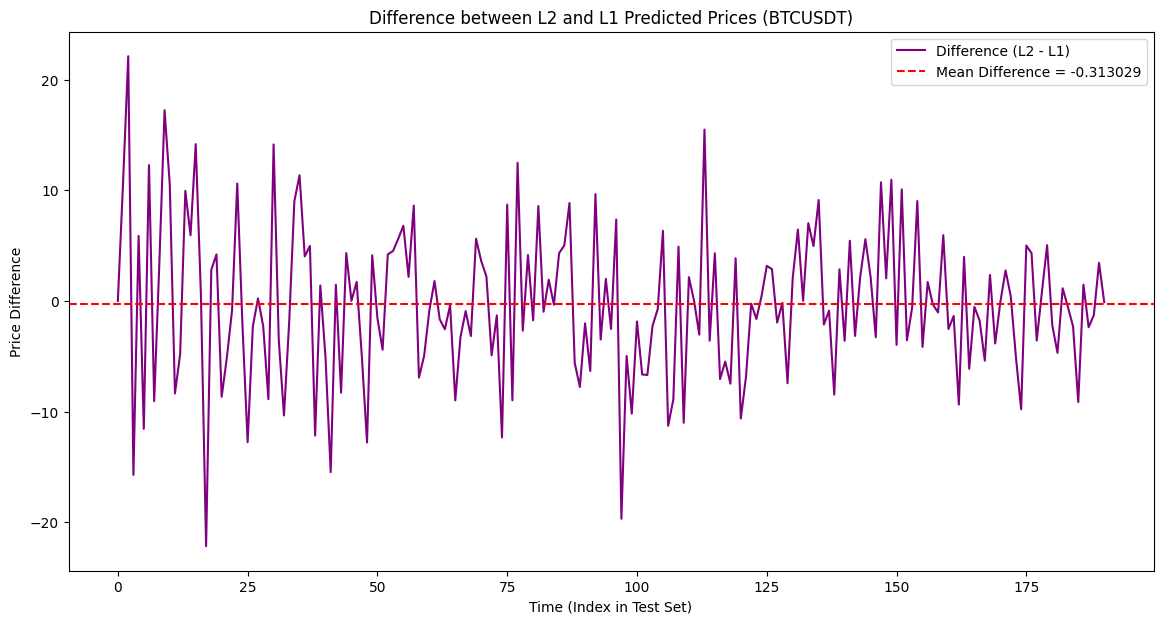

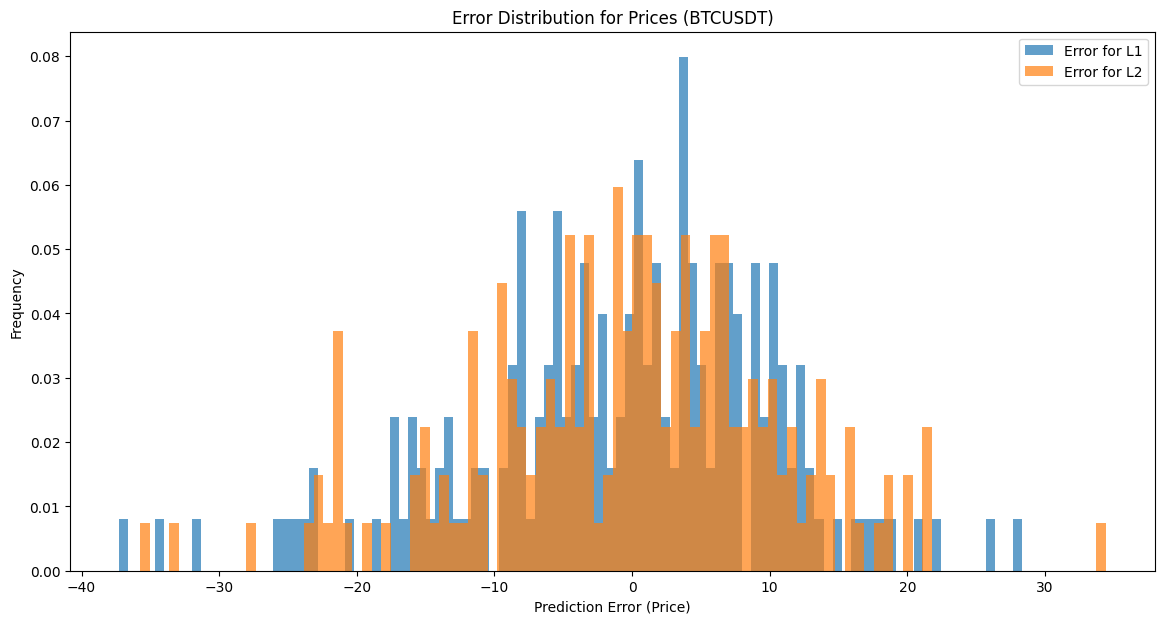

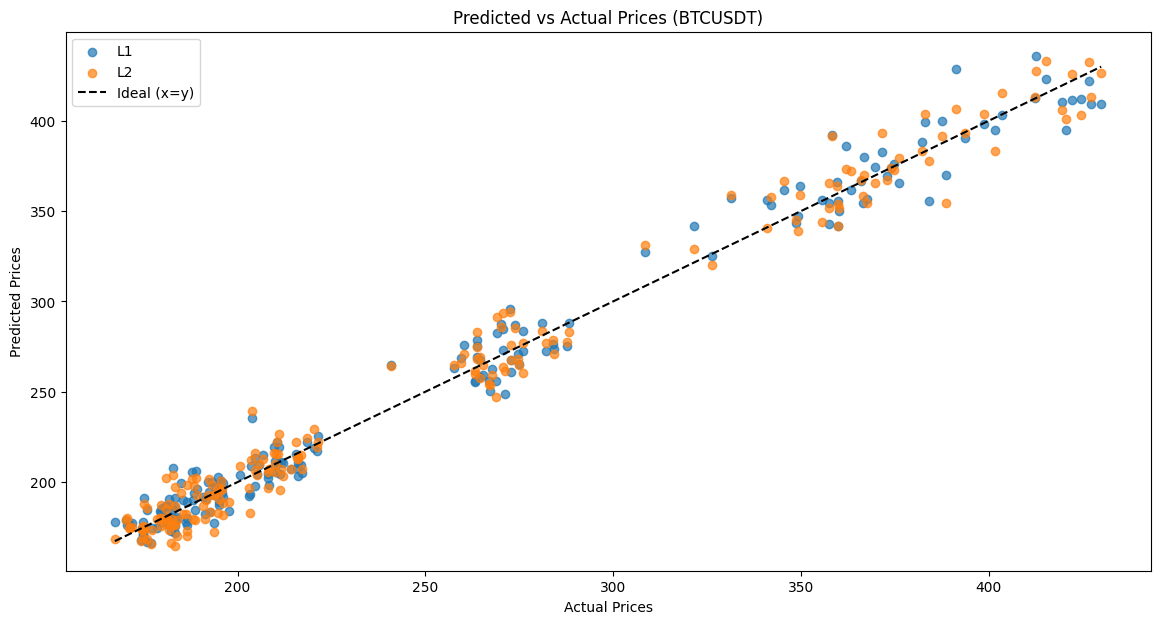

In [172]:
# Un-standardize the test returns
actual_returns = y_test.flatten() * returns_std + returns_mean
start_index = 0  # They are aligned with the test set

# 1. Line Plot: Actual vs Predicted Returns
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_returns)), actual_returns, 
         label='Actual Returns', color='black', linewidth=1)
plt.plot(range(len(predict_returns["L1"])), predict_returns["L1"], 
         label='Predicted Returns (L1)')
plt.plot(range(len(predict_returns["L2"])), predict_returns["L2"], 
         label='Predicted Returns (L2)')
plt.xlabel('Time (Index)')
plt.ylabel('Log Return')
plt.title(f'Actual vs Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 2. Difference between L2 and L1 Predicted Returns
diff_series = predict_returns["L2"] - predict_returns["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 6)
diff_dist = np.mean(actual_returns) - np.median(actual_returns)
diff_mean_dist = np.mean(diff_dist)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted returns:", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time (Index)')
plt.ylabel('Return Difference')
plt.title(f'Difference between L2 and L1 Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Returns (Error = Actual - Predicted)
errors_L1 = actual_returns - predict_returns["L1"]
errors_L2 = actual_returns - predict_returns["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Return)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Returns ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Returns
plt.figure(figsize=(14, 7))
plt.scatter(actual_returns, predict_returns["L1"], alpha=0.7, label='L1')
plt.scatter(actual_returns, predict_returns["L2"], alpha=0.7, label='L2')
ideal_line = [min(actual_returns), max(actual_returns)]
plt.plot(ideal_line, ideal_line, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Predicted vs Actual Returns ({ticker})')
plt.legend()
plt.show()

##########################################################

# Both actual_prices and predicted_prices are assumed to have been reconstructed (length = len(y_test)+1)

# 1. Line Plot: Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_prices)), actual_prices, 
         label='Actual Prices', color='black', linewidth=1)
plt.plot(range(len(predicted_prices["L1"])), predicted_prices["L1"], 
         label='Predicted Prices (L1)')
plt.plot(range(len(predicted_prices["L2"])), predicted_prices["L2"], 
         label='Predicted Prices (L2)')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Difference between L2 and L1 Predicted Prices
diff_series_prices = predicted_prices["L2"] - predicted_prices["L1"]
diff_mean_prices = np.mean(diff_series_prices)
mean_rounded_prices = round(diff_mean_prices, 6)
diff_dist_prices = np.mean(actual_prices) - np.median(actual_prices)
diff_mean_dist = np.mean(diff_dist_prices)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted prices:", mean_rounded_prices)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series_prices)), diff_series_prices, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean_prices, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded_prices}')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price Difference')
plt.title(f'Difference between L2 and L1 Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Prices (Error = Actual - Predicted)
errors_prices_L1 = actual_prices - predicted_prices["L1"]
errors_prices_L2 = actual_prices - predicted_prices["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_prices_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_prices_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Price)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Prices ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Prices
plt.figure(figsize=(14, 7))
plt.scatter(actual_prices, predicted_prices["L1"], alpha=0.7, label='L1')
plt.scatter(actual_prices, predicted_prices["L2"], alpha=0.7, label='L2')
ideal_line_prices = [min(actual_prices), max(actual_prices)]
plt.plot(ideal_line_prices, ideal_line_prices, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Predicted vs Actual Prices ({ticker})')
plt.legend()
plt.show()


### Bitcoin Series (Régimen Volátil)


Succesfully connected to the Binance Spot API at 2025-04-04 03:16:55.911621 

Succesfully connected to the Binance Futures API at 2025-04-04 03:16:56.279374 



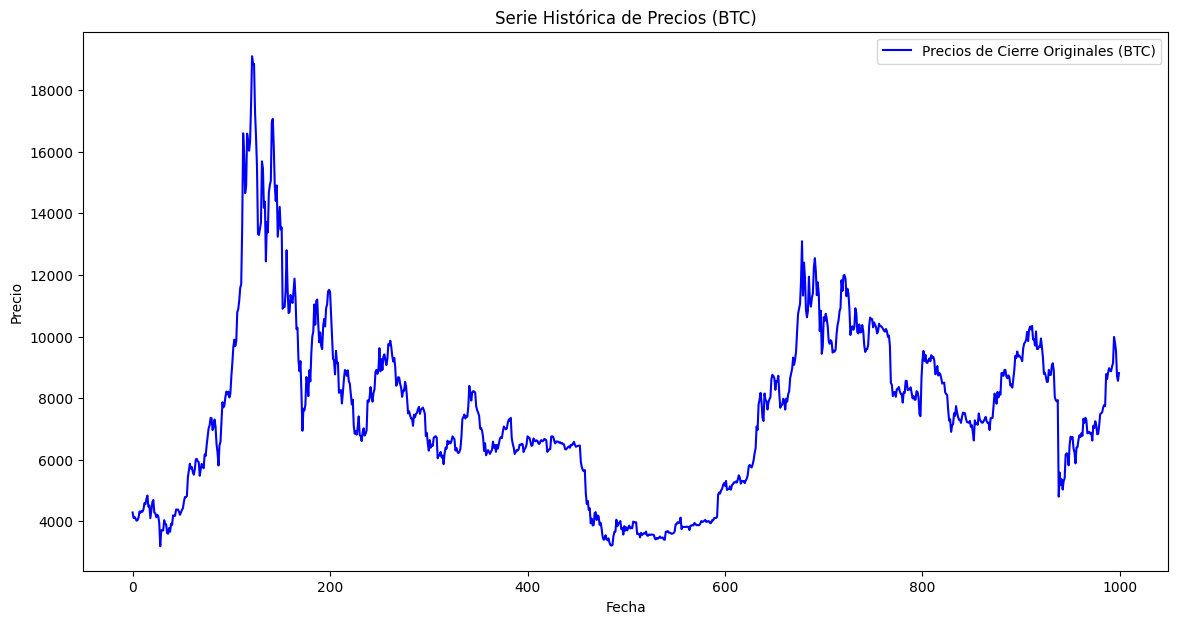

In [173]:
seed = 3254
np.random.seed(seed)
tf.random.set_seed(seed)
tf.data.experimental.enable_debug_mode()

loss_functions = {
    "L1": "mae",
    "L2": "mse",
}

load_dotenv(".env")
api_key = os.getenv("BINANCE_API_KEY")
secret_key = os.getenv("BINANCE_SECRET_KEY")
exchange_name = "binance"  # o el enum correspondiente

# Inicializar la API de Binance (asegúrate de que BinanceProvider esté implementado)
binance_api = BinanceProvider(api_key=api_key, api_secret=secret_key)
binance_api.connect()

# Definir rango de fechas: 2020-01-01 a 2025-01-01
start = datetime(2015, 1, 1)
end = datetime(2021, 1, 1)
ticker = "BTCUSDT"

# Obtener datos históricos de BTC (frecuencia diaria)
btc_klines = binance_api.get_market_data(symbol=TokenPairs.btc_usdt, freq="1d", start=start, end=end)
# Suponemos que btc_klines es un DataFrame con una columna 'close' y un índice con las fechas.
token_prices = np.array(btc_klines['close'])
token_prices = token_prices.reshape(-1)  # Asegurarse de que es 1D

plt.figure(figsize=(14,7))
plt.plot(range(0,len(btc_klines['close'])), btc_klines['close'], label='Precios de Cierre Originales (BTC)', color='blue')
plt.xlabel('Fecha')
plt.ylabel('Precio')
plt.title('Serie Histórica de Precios (BTC)')
plt.legend()
plt.show()

prices_series = pd.Series(token_prices)
pd_stock = prices_series.shift(1)
returns = np.log(prices_series) - np.log(pd_stock)
returns = returns.dropna()
returns = returns.values  # Array 1D de log-retornos

# Calcular media y desviación estándar (para invertir la estandarización)
returns_mean = returns.mean()
returns_std = returns.std()
standardized_returns = (returns - returns_mean) / returns_std

# Definir la longitud de la secuencia (número de retornos pasados a usar como entrada)
seq_length = 50

X = []
y = []
for i in range(len(standardized_returns) - seq_length):
    X.append(standardized_returns[i:i + seq_length])
    y.append(standardized_returns[i + seq_length])
    
X = np.array(X)
y = np.array(y)

# Dividir en entrenamiento y test (80% entrenamiento, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split].reshape(-1, 1), y[split:].reshape(-1, 1)

def build_model():
    model = keras.models.Sequential([
        keras.layers.Input(shape=(seq_length,)),
        keras.layers.Dense(128, activation='relu'),
        keras.layers.Dense(1, activation='linear')
    ])
    return model

predict_returns = {} 

In [174]:
for title, selected_loss in loss_functions.items():
    print(f"Training model with {title} loss function.")
    model = build_model()
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(optimizer=optimizer, loss=selected_loss)
    model.fit(X_train, y_train, batch_size=16, epochs=100, verbose=0)
    
    # Predict on the test set (predictions are in standardized space)
    predictions_std = model.predict(X_test).flatten()
    
    # Inverse transform to obtain returns in original scale:
    predictions_ret = predictions_std * returns_std + returns_mean
    predict_returns[title] = predictions_ret

Training model with L1 loss function.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Training model with L2 loss function.
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 


In [175]:
# Print a few predicted returns for each loss function
for loss_name, preds in predict_returns.items():
    print(f"{loss_name} predicted returns (first 10): {preds[:10]}")

# The first label in the test set corresponds to the stock price at index (split + seq_length) in stock_prices
initial_test_price = stock_prices[split + seq_length]

# Reconstruct the actual prices for the test period from the actual test returns
# First, un-standardize the actual test returns:

actual_test_returns = y_test.flatten() * returns_std + returns_mean
actual_prices = [initial_test_price]
for r in actual_test_returns:
    next_price = actual_prices[-1] * np.exp(r)
    actual_prices.append(next_price)
actual_prices = np.array(actual_prices)

# Reconstruct predicted prices for each loss function using:
# P_{t+1} = P_t * exp(r_{t+1})
predicted_prices = {}
for title, pred_ret in predict_returns.items():
    prices_list = [initial_test_price]
    for i, r in enumerate(pred_ret):
        next_price = actual_prices[i] * np.exp(r)
        prices_list.append(next_price)
    predicted_prices[title] = np.array(prices_list)

L1 predicted returns (first 10): [-0.02921537 -0.00244055  0.00094134 -0.00028548 -0.01394826 -0.0695894
 -0.05292304  0.01713196 -0.02478207  0.02873768]
L2 predicted returns (first 10): [-0.03614169  0.01423745  0.02821674 -0.01063437 -0.03234722 -0.06005345
  0.02335589  0.01009063 -0.00068214  0.03900716]


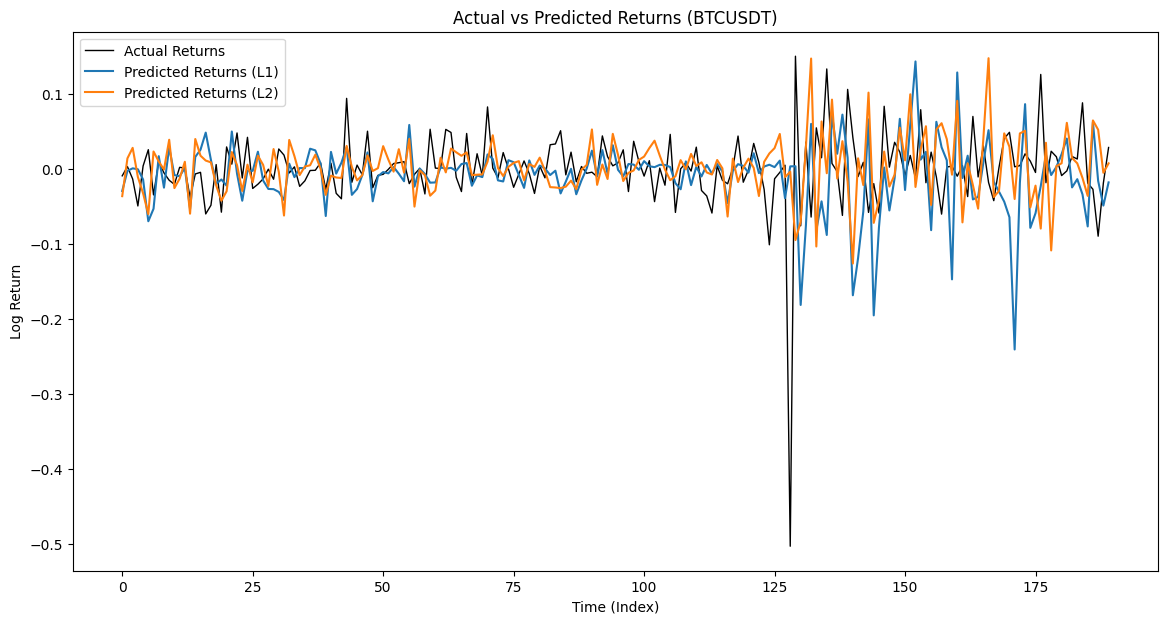

Observed Mean Difference between Mean and Median for prices: -0.000366
Observed Mean Difference between L2 and L1 predicted returns: 0.011102


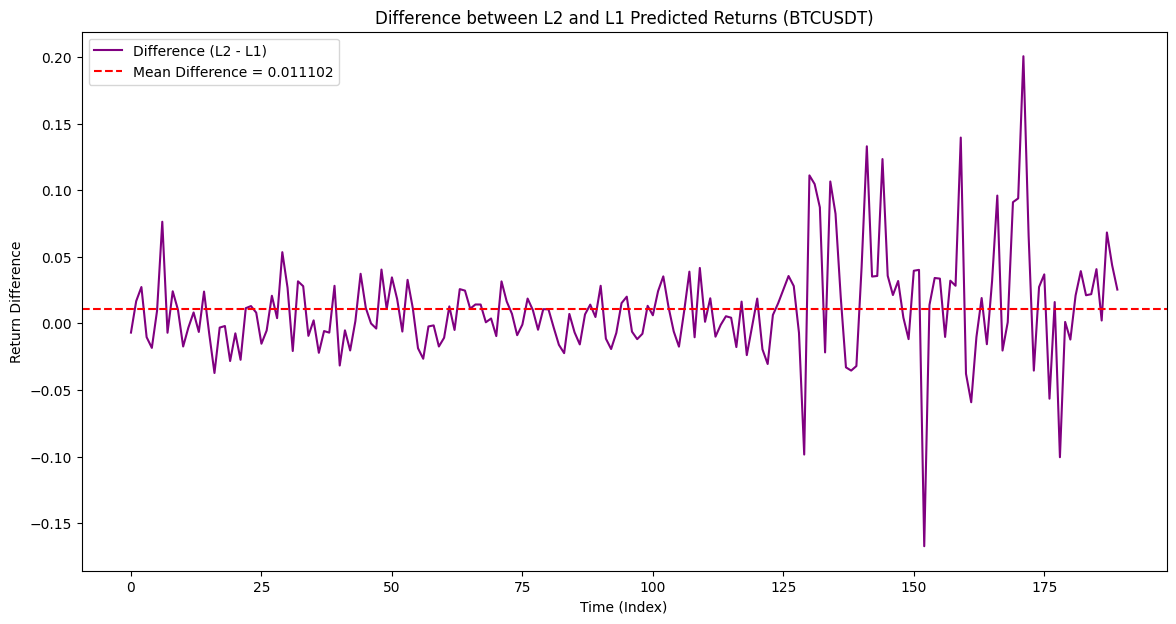

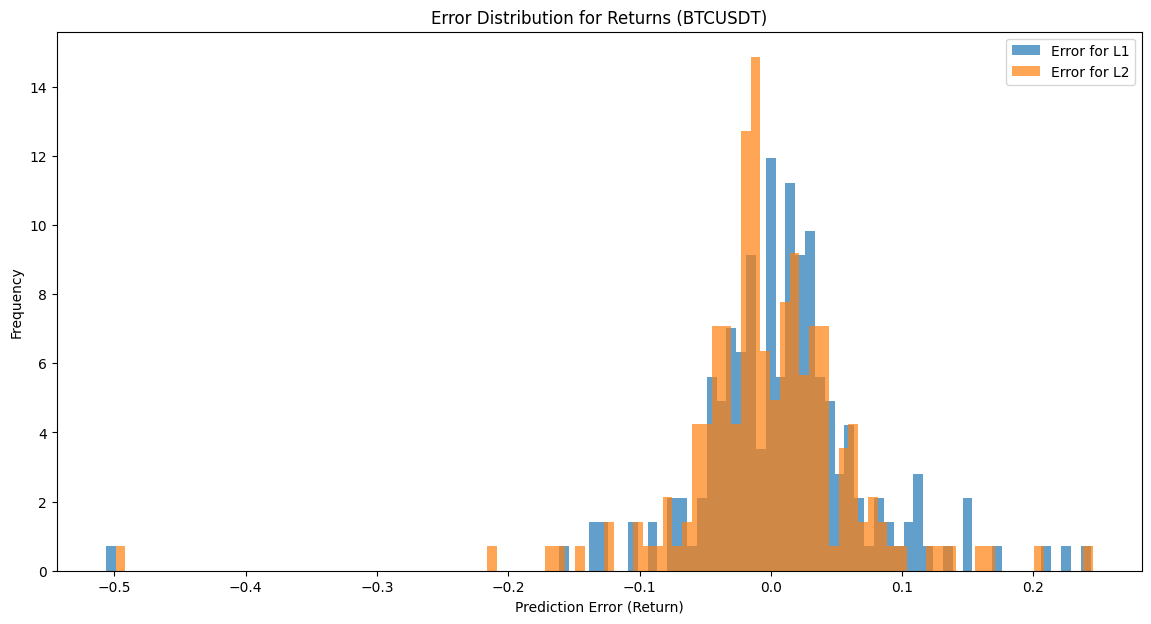

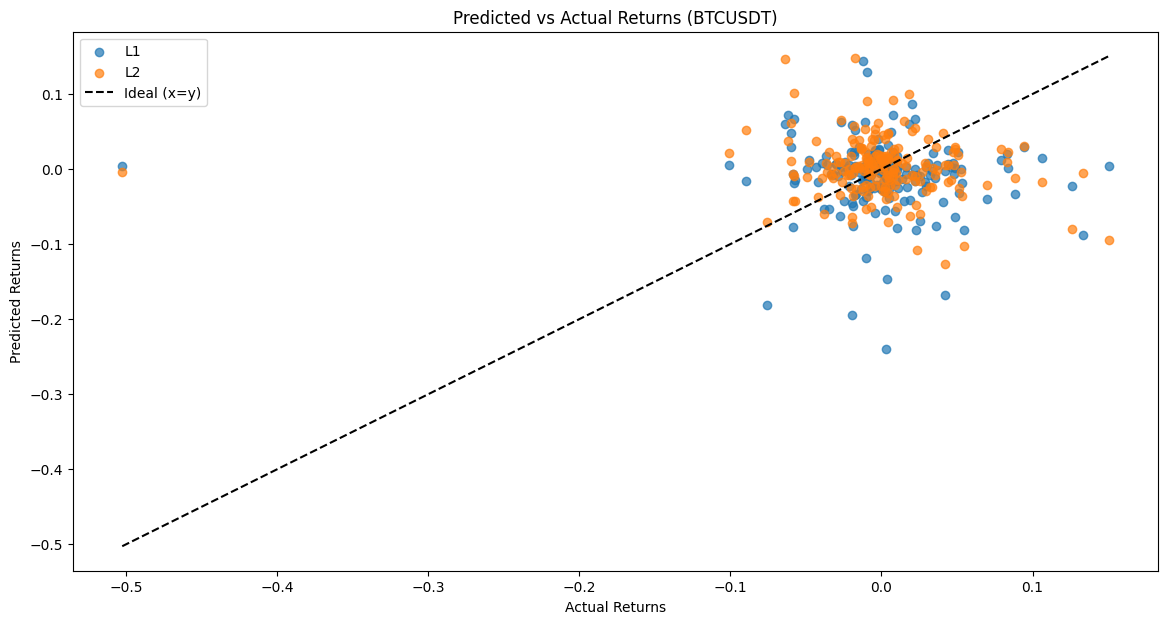

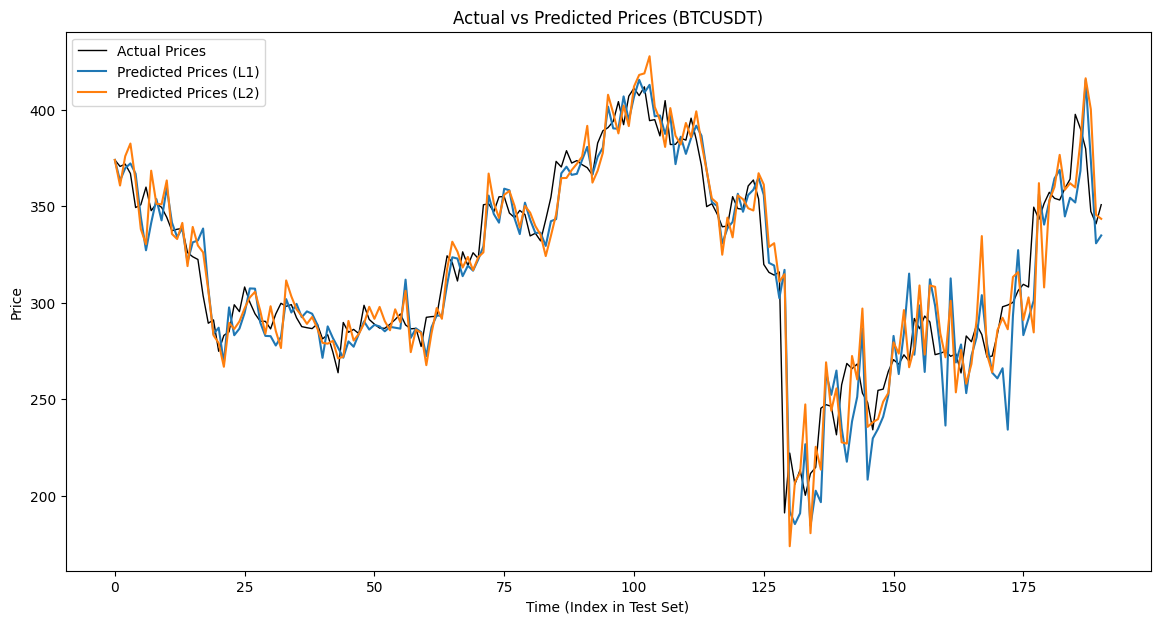

Observed Mean Difference between Mean and Median for prices: 6.487949
Observed Mean Difference between L2 and L1 predicted prices: 3.180897


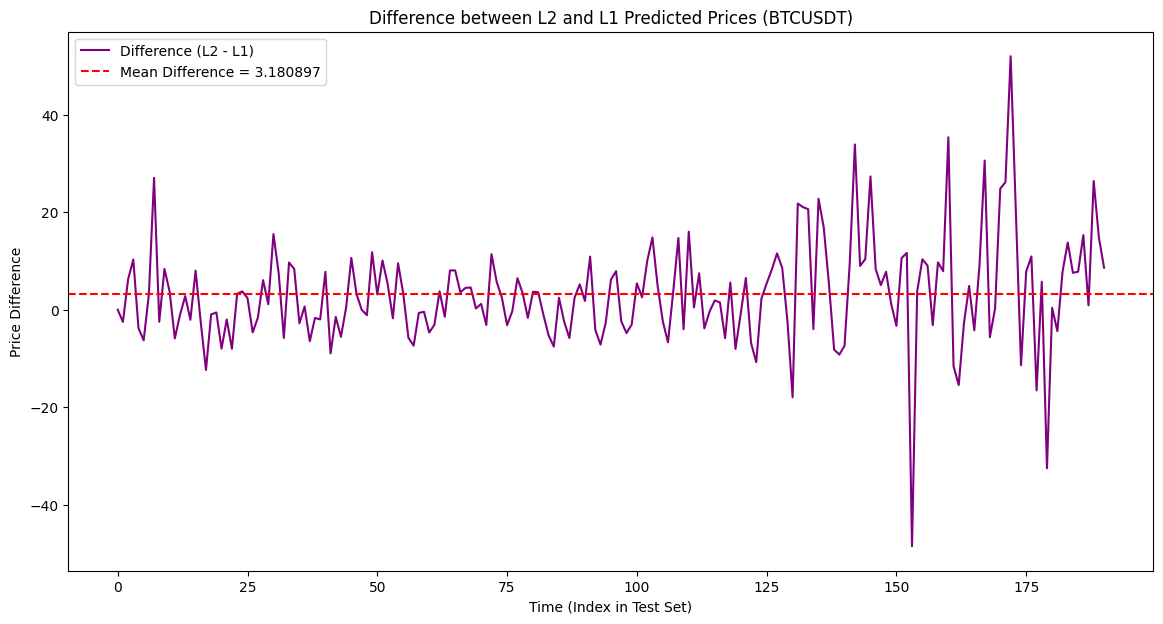

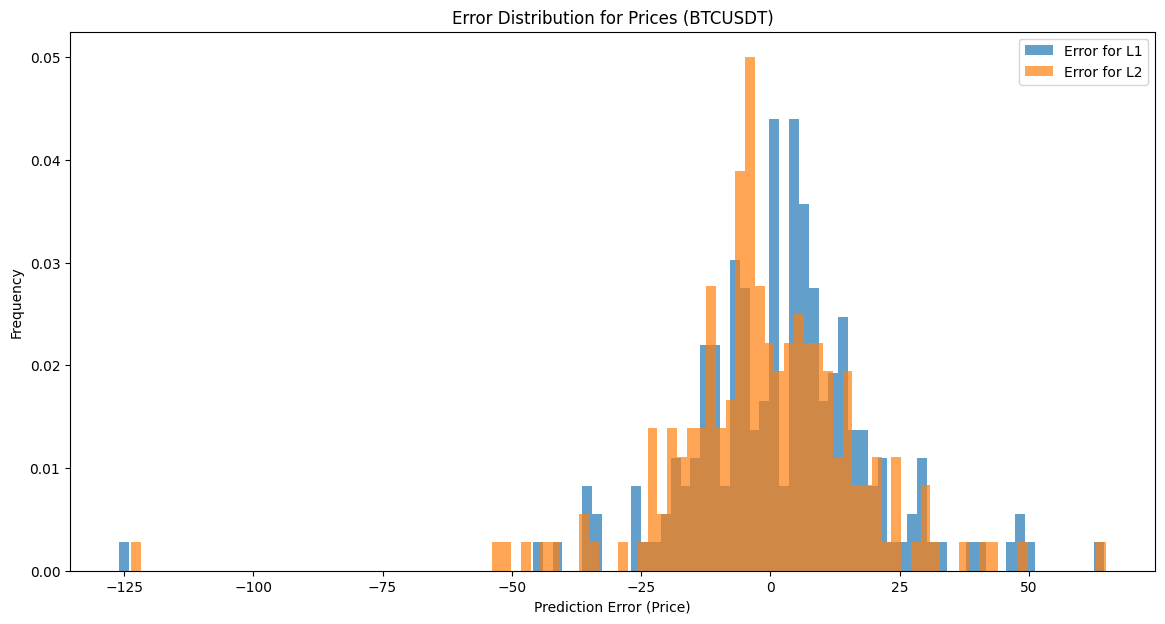

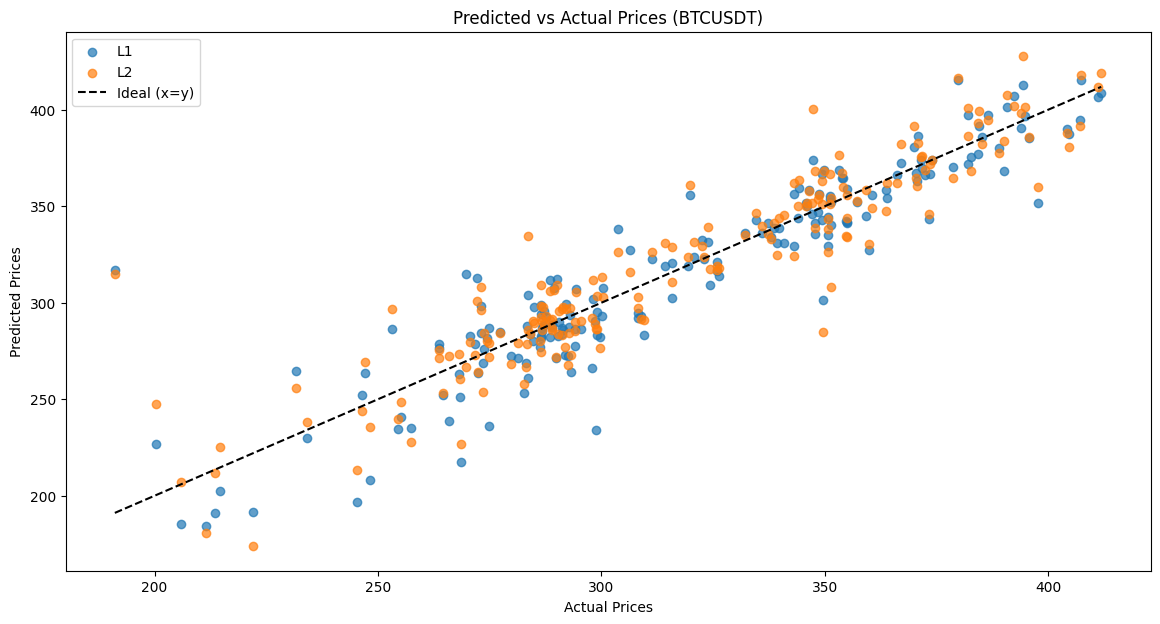

In [176]:
# Un-standardize the test returns
actual_returns = y_test.flatten() * returns_std + returns_mean
start_index = 0  # They are aligned with the test set

# 1. Line Plot: Actual vs Predicted Returns
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_returns)), actual_returns, 
         label='Actual Returns', color='black', linewidth=1)
plt.plot(range(len(predict_returns["L1"])), predict_returns["L1"], 
         label='Predicted Returns (L1)')
plt.plot(range(len(predict_returns["L2"])), predict_returns["L2"], 
         label='Predicted Returns (L2)')
plt.xlabel('Time (Index)')
plt.ylabel('Log Return')
plt.title(f'Actual vs Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 2. Difference between L2 and L1 Predicted Returns
diff_series = predict_returns["L2"] - predict_returns["L1"]
diff_mean = np.mean(diff_series)
mean_rounded = round(diff_mean, 6)
diff_dist = np.mean(actual_returns) - np.median(actual_returns)
diff_mean_dist = np.mean(diff_dist)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted returns:", mean_rounded)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series)), diff_series, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded}')
plt.xlabel('Time (Index)')
plt.ylabel('Return Difference')
plt.title(f'Difference between L2 and L1 Predicted Returns ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Returns (Error = Actual - Predicted)
errors_L1 = actual_returns - predict_returns["L1"]
errors_L2 = actual_returns - predict_returns["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Return)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Returns ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Returns
plt.figure(figsize=(14, 7))
plt.scatter(actual_returns, predict_returns["L1"], alpha=0.7, label='L1')
plt.scatter(actual_returns, predict_returns["L2"], alpha=0.7, label='L2')
ideal_line = [min(actual_returns), max(actual_returns)]
plt.plot(ideal_line, ideal_line, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Returns')
plt.ylabel('Predicted Returns')
plt.title(f'Predicted vs Actual Returns ({ticker})')
plt.legend()
plt.show()

##########################################################

# Both actual_prices and predicted_prices are assumed to have been reconstructed (length = len(y_test)+1)

# 1. Line Plot: Actual vs Predicted Prices
plt.figure(figsize=(14, 7))
plt.plot(range(len(actual_prices)), actual_prices, 
         label='Actual Prices', color='black', linewidth=1)
plt.plot(range(len(predicted_prices["L1"])), predicted_prices["L1"], 
         label='Predicted Prices (L1)')
plt.plot(range(len(predicted_prices["L2"])), predicted_prices["L2"], 
         label='Predicted Prices (L2)')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price')
plt.title(f'Actual vs Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Difference between L2 and L1 Predicted Prices
diff_series_prices = predicted_prices["L2"] - predicted_prices["L1"]
diff_mean_prices = np.mean(diff_series_prices)
mean_rounded_prices = round(diff_mean_prices, 6)
diff_dist_prices = np.mean(actual_prices) - np.median(actual_prices)
diff_mean_dist = np.mean(diff_dist_prices)
mean_rounded_dist = round(diff_mean_dist, 6)

print("Observed Mean Difference between Mean and Median for prices:", mean_rounded_dist)
print("Observed Mean Difference between L2 and L1 predicted prices:", mean_rounded_prices)

plt.figure(figsize=(14, 7))
plt.plot(range(len(diff_series_prices)), diff_series_prices, label='Difference (L2 - L1)', color='purple')
plt.axhline(y=diff_mean_prices, color='red', linestyle='--', label=f'Mean Difference = {mean_rounded_prices}')
plt.xlabel('Time (Index in Test Set)')
plt.ylabel('Price Difference')
plt.title(f'Difference between L2 and L1 Predicted Prices ({ticker})')
plt.legend()
plt.show()

# 3. Histogram of Errors in Prices (Error = Actual - Predicted)
errors_prices_L1 = actual_prices - predicted_prices["L1"]
errors_prices_L2 = actual_prices - predicted_prices["L2"]

plt.figure(figsize=(14, 7))
plt.hist(errors_prices_L1, bins=100, alpha=0.7, label='Error for L1', density=True)
plt.hist(errors_prices_L2, bins=100, alpha=0.7, label='Error for L2', density=True)
plt.xlabel('Prediction Error (Price)')
plt.ylabel('Frequency')
plt.title(f'Error Distribution for Prices ({ticker})')
plt.legend()
plt.show()

# 4. Additional Scatter Plot: Predicted vs Actual Prices
plt.figure(figsize=(14, 7))
plt.scatter(actual_prices, predicted_prices["L1"], alpha=0.7, label='L1')
plt.scatter(actual_prices, predicted_prices["L2"], alpha=0.7, label='L2')
ideal_line_prices = [min(actual_prices), max(actual_prices)]
plt.plot(ideal_line_prices, ideal_line_prices, 'k--', label='Ideal (x=y)')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title(f'Predicted vs Actual Prices ({ticker})')
plt.legend()
plt.show()
